# Compare anonymization algorithms

In this notebook, we implement K-anonymization algorithms: ML anonymization module and Mondrian (+l-diverse), and differential privacy. 

We will demonstrate running membership and attribute inference attacks both on a vanilla model, and then on an anonymized versions of the model. We use ART's inference module (https://github.com/Trusted-AI/adversarial-robustness-toolbox/tree/main/art/attacks/inference). 

This will be demonstarted using the Adult dataset (original dataset can be found here: https://archive.ics.uci.edu/ml/datasets/adult).

The sensitive feature we are trying to infer is the 'relationship' feature, after turning it into a binary feature ('wife' and 'husband' vs the rest). 

We also preprocess the data such that all categorical features are one-hot encoded.

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Load data

In [2]:
from apt.utils.dataset_utils import get_adult_dataset_pd


(x_train, y_train), (x_test, y_test) = get_adult_dataset_pd()

x_train

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,UnitedStates
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,UnitedStates
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,UnitedStates
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,UnitedStates
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Other
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,UnitedStates
32557,40,Private,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,UnitedStates
32558,58,Private,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,UnitedStates
32559,22,Private,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,UnitedStates


## Modify the race values

In [3]:
def binarlize_column(value):
    if value == 'Wife' or value == 'Husband':
        return "Wife_or_Husband"
    else:
        return "The_others"

bin_column = 'relationship'
x_train[bin_column] = x_train[bin_column].apply(binarlize_column)
x_test[bin_column] = x_test[bin_column].apply(binarlize_column)
x_train

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,13,Never-married,Adm-clerical,The_others,White,Male,2174,0,40,UnitedStates
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Wife_or_Husband,White,Male,0,0,13,UnitedStates
2,38,Private,9,Divorced,Handlers-cleaners,The_others,White,Male,0,0,40,UnitedStates
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Wife_or_Husband,Black,Male,0,0,40,UnitedStates
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife_or_Husband,Black,Female,0,0,40,Other
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,12,Married-civ-spouse,Tech-support,Wife_or_Husband,White,Female,0,0,38,UnitedStates
32557,40,Private,9,Married-civ-spouse,Machine-op-inspct,Wife_or_Husband,White,Male,0,0,40,UnitedStates
32558,58,Private,9,Widowed,Adm-clerical,The_others,White,Female,0,0,40,UnitedStates
32559,22,Private,9,Never-married,Adm-clerical,The_others,White,Male,0,0,20,UnitedStates


In [4]:
# fix type error in x_test
convert_dict = x_train.dtypes
x_test = x_test.astype(convert_dict)
x_test.dtypes

age                int64
workclass         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
dtype: object

In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


numeric_features = x_train.select_dtypes(['int64']).columns.to_list()
categorical_features = x_train.select_dtypes(['object']).columns.to_list()

numeric_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(strategy='constant', fill_value=0))]
)

categorical_transformer = Pipeline(
    steps=[('hotencoder', OneHotEncoder(handle_unknown="ignore", sparse=False, drop="if_binary"))]
)
    
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

x_train_encoded = preprocessor.fit_transform(x_train)
x_test_encoded = preprocessor.transform(x_test)    

In [6]:
from art.estimators.classification.scikitlearn import ScikitlearnDecisionTreeClassifier
from anonymcmp_utils import *
import numpy as np

def measure_DTaccuracies(optmodel):
    classifier = ScikitlearnDecisionTreeClassifier(optmodel)
    pred_acc = optmodel.score(x_test_encoded, y_test)
    
    mmb_acc = measure_membership_attack_accuracy(classifier, x_train_encoded, y_train, x_test_encoded, y_test, 
                                                 attack_train_size, attack_test_size)

    x_train_encoded_predictions = np.array([np.argmax(arr) for arr in classifier.predict(x_train_encoded)]).reshape(-1,1)
    
    attrb_acc = measure_attribute_bbox_attack_accuracy(classifier, x_train_encoded, attack_train_size, 
                                                       x_train_encoded_predictions, attack_feature, 
                                                       x_train_for_attack, values, x_train_feature)    
    
    attrlw_acc = measure_attribute_wboxLDT_attack_accuracy(classifier, x_train_encoded_predictions, attack_feature, 
                                                           x_train_for_attack, values, priors, x_train_feature)

    attrw_acc = measure_attribute_wboxDT_attack_accuracy(classifier, x_train_encoded_predictions, attack_feature, 
                                                         x_train_for_attack, values, priors, x_train_feature)

    return [pred_acc, mmb_acc, attrb_acc, attrlw_acc, attrw_acc]

## Vanilla model

In [7]:
from sklearn.tree import DecisionTreeClassifier
from art.estimators.classification.scikitlearn import ScikitlearnDecisionTreeClassifier

vanilla_model = DecisionTreeClassifier()
vanilla_model = vanilla_model.fit(x_train_encoded, y_train)

# use half of each dataset for training the attack
attack_train_ratio = 0.5
attack_train_size = int(len(x_train_encoded) * attack_train_ratio)
attack_test_size = int(len(x_test_encoded) * attack_train_ratio)

#attribute inference
attack_column = bin_column

hotencoder_feature_names = preprocessor.named_transformers_['cat'].named_steps['hotencoder'].get_feature_names(categorical_features)
idx_attack_hotencoder = int(np.argwhere([attack_column in f for f in hotencoder_feature_names])[0][0])
attack_feature = len(preprocessor.transformers[0][-1]) + idx_attack_hotencoder

# training data without attacked feature
x_train_for_attack = np.delete(x_train_encoded, attack_feature, 1)
# only attacked feature
x_train_feature = x_train_encoded[:, attack_feature].copy()

# get inferred values
values = np.unique(x_train_feature)

priors = [(x_train_feature == v).sum()/len(x_train_feature) for v in values]

acc_vanilla = measure_DTaccuracies(vanilla_model)

## Anonymized data
### ML anonymization module
Now we will apply the same attacks on an anonymized versions (ML anonymization module, Mondrian and differential privacy) of the same dataset. The data is anonymized on the quasi-identifiers: age, education-num, capital-gain, hours-per-week.

In [8]:
from apt.utils.datasets import ArrayDataset
from apt.anonymization import Anonymize

QI = ['age', 'education-num', 'race', 'relationship']

k_trials = (50, 100, 200, 400, 800, 1000)


x_train_predictions = np.array([np.argmax(arr) for arr in ScikitlearnDecisionTreeClassifier(vanilla_model).predict(x_train_encoded)]).reshape(-1,1)

def measure_mlanoym_DTaccuracies(k):
    anonymizer = Anonymize(k, QI, categorical_features=categorical_features)
    anon = anonymizer.anonymize(ArrayDataset(x_train, x_train_predictions))
    anon = anon.astype(convert_dict)
    
    anon_encoded = preprocessor.transform(anon)

    anon_model = DecisionTreeClassifier()
    anon_model = anon_model.fit(anon_encoded, y_train)
    
    return measure_DTaccuracies(anon_model)

accuracies_ML = [measure_mlanoym_DTaccuracies(k) for k in k_trials]

### Mondrian

In [9]:
from mondrian import anonymize, MondrianOption

sensitive_column = bin_column

def measure_mondrian_DTaccuracies(k, option, l_or_p=1):
    anon = anonymize(x_train, set(categorical_features), QI, sensitive_column, k, option, l_or_p)
    anon = anon.astype(convert_dict)
    
    anon_encoded = preprocessor.transform(anon)
    
    anon_model = DecisionTreeClassifier()
    anon_model = anon_model.fit(anon_encoded, y_train)
    
    return measure_DTaccuracies(anon_model)
 
accuracies_mondrian = [measure_mondrian_DTaccuracies(k, MondrianOption.Non) for k in k_trials]

#### l-diversity l=2

In [10]:
accuracies_ldiv = [measure_mondrian_DTaccuracies(k, MondrianOption.ldiv, 2) for k in k_trials]

#### t-closeness p=0.2

In [12]:
accuracies_tclose = [measure_mondrian_DTaccuracies(k, MondrianOption.tclose, 0.2) for k in k_trials]

### Differential privacy

In [13]:
import diffprivlib.models as dp
from art.estimators.classification.scikitlearn import ScikitlearnDecisionTreeClassifier

epsilons = [0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 25.0, 75.0, 100.0, 200.0]

def measure_dp_DTaccuracies(eps):
    dp_clf = dp.DecisionTreeClassifier(epsilon=eps)
    dp_clf = dp_clf.fit(x_train_encoded, y_train)
    
    return measure_DTaccuracies(dp_clf)

accuracies_dp = [measure_dp_DTaccuracies(eps) for eps in epsilons]

/anonym/diffprivlib/models/forest.py:419: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  warnings.warn("Bounds have not been specified and will be calculated on the data provided. This will "
/anonym/diffprivlib/models/forest.py:427: PrivacyLeakWarning: Classes have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify the prediction classes for model.
  warnings.warn("Classes have not been specified and will be calculated on the data provided. This will "
/anonym/diffprivlib/models/forest.py:419: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differentia

## Comparison

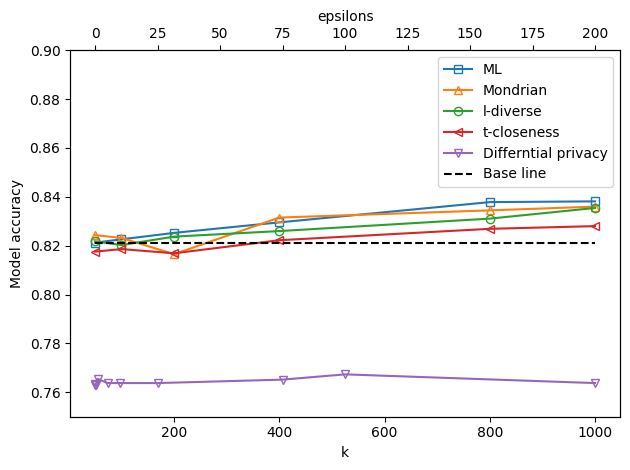

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

lns1 = ax.plot(k_trials, np.array(accuracies_ML)[:,0], '-s', fillstyle='none', label="ML")
lns2 = ax.plot(k_trials, np.array(accuracies_mondrian)[:,0], '-^', fillstyle='none', label="Mondrian")
lns5 = ax.plot(k_trials, np.array(accuracies_ldiv)[:,0], '-o', fillstyle='none', label="l-diverse")
lns6 = ax.plot(k_trials, np.array(accuracies_tclose)[:,0], '-<', fillstyle='none', label="t-closeness")
lns3 = ax.plot(k_trials, np.ones_like(k_trials) * acc_vanilla[0], '--', label="Base line", color='black')
ax.set_xlabel("k")
ax.set_ylabel("Model accuracy")
ax.set_ylim(0.75, 0.9)

ax2 = ax.twiny()
lns4 = ax2.plot(epsilons, np.array(accuracies_dp)[:,0], '-v', fillstyle='none', label="Differntial privacy", color='tab:purple')
ax2.set_xlabel("epsilons")
ax2.xaxis.set_label_position('top') 
ax2.xaxis.tick_top()
ax2.set_ylim(0.75, 0.9)

lns = lns1+lns2+lns5+lns6+lns4+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs)
#ax.legend(lns, labs, loc='center left', bbox_to_anchor=(1, 0.5))


fig.tight_layout()
plt.show()

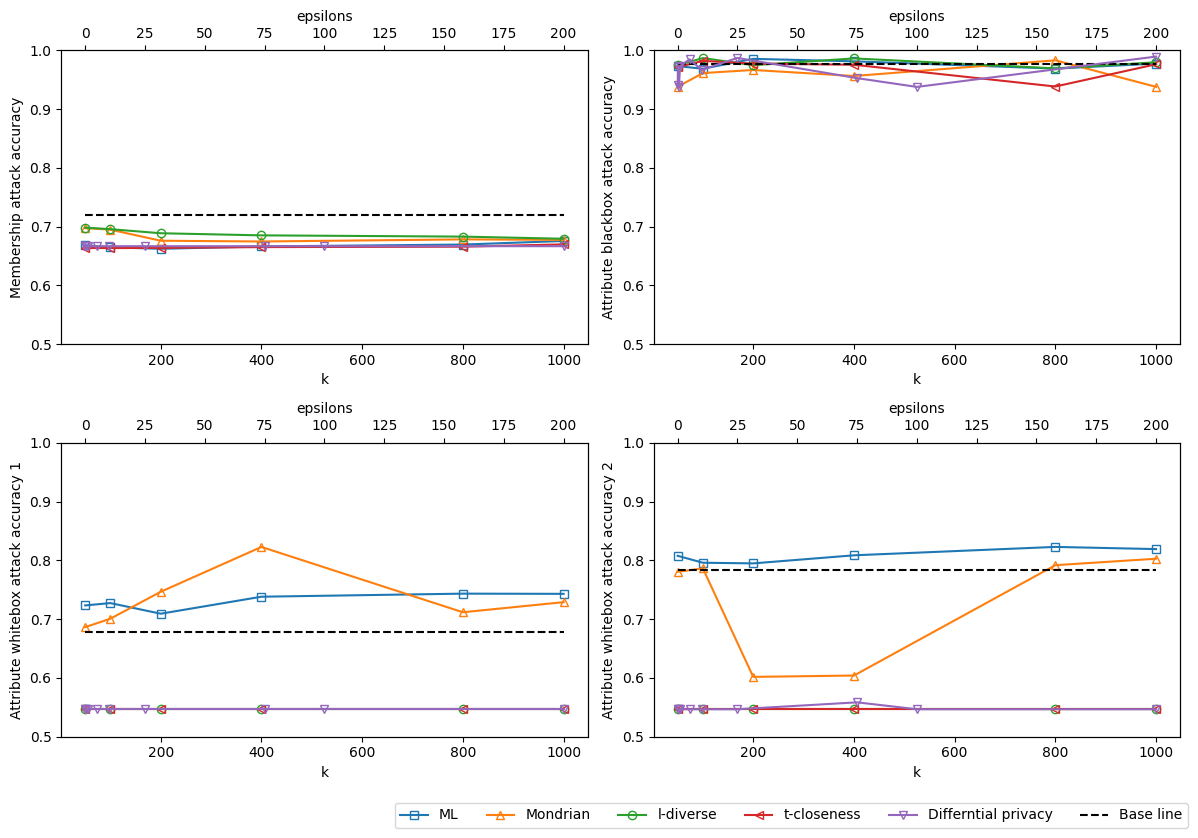

In [14]:
ylabels = ["Membership attack accuracy", "Attribute blackbox attack accuracy",
           "Attribute whitebox attack accuracy 1", "Attribute whitebox attack accuracy 2"]

fig, axs = plt.subplots(2, 2, figsize=(12,8))

for ax, i, j in zip(axs.flatten(), range(len(ylabels)), range(1, len(ylabels)+1)):
    lns1 = ax.plot(k_trials, np.array(accuracies_ML)[:,j], '-s', fillstyle='none', label="ML")
    lns2 = ax.plot(k_trials, np.array(accuracies_mondrian)[:,j], '-^', fillstyle='none', label="Mondrian")
    lns5 = ax.plot(k_trials, np.array(accuracies_ldiv)[:,j], '-o', fillstyle='none', label="l-diverse")
    lns6 = ax.plot(k_trials, np.array(accuracies_tclose)[:,j], '-<', fillstyle='none', label="t-closeness")
    lns3 = ax.plot(k_trials, np.ones_like(k_trials) * acc_vanilla[j], '--', label="Base line", color='black')

    ax.set_xlabel("k")
    ax.set_ylabel(ylabels[i])
    ax.set_ylim(0.5, 1.0)

    ax2 = ax.twiny()
    lns4 = ax2.plot(epsilons, np.array(accuracies_dp)[:,j], '-v', fillstyle='none', label="Differntial privacy", color='tab:purple')
    ax2.set_xlabel("epsilons")
    ax2.xaxis.set_label_position('top') 
    ax2.xaxis.tick_top()
    ax2.set_ylim(0.5, 1.0)

    lns = lns1+lns2+lns5+lns6+lns4+lns3
    labs = [l.get_label() for l in lns]

fig.legend(lns, labs, loc='lower right', ncol=6, bbox_to_anchor=(1.0, -0.05))
fig.tight_layout()
plt.show()

## Save results

In [27]:
np.save('results/anonymization_adult-levels.npy', (acc_vanilla, accuracies_ML, accuracies_mondrian, accuracies_ldiv, accuracies_tclose, accuracies_dp), allow_pickle=True)